<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Category-Encoding" data-toc-modified-id="Category-Encoding-1">Category Encoding</a></span></li><li><span><a href="#Scaling" data-toc-modified-id="Scaling-2">Scaling</a></span></li><li><span><a href="#load-model-from-pickle-file" data-toc-modified-id="load-model-from-pickle-file-3">load model from pickle file</a></span></li><li><span><a href="#ROC-Curve" data-toc-modified-id="ROC-Curve-4">ROC Curve</a></span></li></ul></div>

This model 

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn import metrics
from matplotlib import style

In [2]:
# Most significant columns according to RFE
red_cols = ['artist', 'album', 'popularity', 'danceability', 'energy', 'loudness','instrumentalness', 'valence']

In [3]:
test = pd.read_csv('../dataset/test.csv')

In [4]:
discover = pd.read_csv('../dataset/discover.csv')

In [5]:
test.drop('Unnamed: 0', axis = 1, inplace = True)

In [6]:
test.head()

,artist,album,track_name,track_id,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,target
0,Arijit Singh,Arijit Singh Broken Strings,"Milne Hai Mujhse Aayi (From ""Aashiqui 2"")",24b9eObMccIrDSs3NvdrRd,45,0.515,0.707,11,-5.467,0,0.0426,0.0357,0.000000,0.1340,0.304,143.752,295798,4,1
1,Skillet,Awake,Monster,2UREu1Y8CO4jXkbvqAtP7g,77,0.640,0.957,8,-2.336,1,0.0741,0.0431,0.000000,0.0789,0.692,134.992,178013,4,1
2,Jeet Gannguli,Musical Bond: Jeet Gannguli & Arijit Singh,"Khamoshiyan (From ""Khamoshiyan"")",50mnqGStE7b577DH2k2ltd,41,0.527,0.521,2,-6.837,0,0.0272,0.6310,0.000000,0.1580,0.266,143.892,335710,3,1
3,Pritam,Jannat 2 (Original Motion Picture Soundtrack),Jannatein Kahan,62wnQra2VgCUyHO3BUIAcr,45,0.545,0.770,0,-6.102,1,0.0655,0.3080,0.000028,0.1670,0.696,159.975,228093,4,0
4,Armaan Malik,Main Rahoon Ya Na Rahoon,Main Rahoon Ya Na Rahoon,6f3ANRNQ8nCiPZ6VqXqq93,60,0.550,0.488,6,-8.059,1,0.0284,0.7180,0.000118,0.1260,0.301,136.025,309458,3,1


In [7]:
y = test['target']
test.drop('target', axis = 1, inplace = True)

In [8]:
test.drop(['track_name', 'track_id'], axis = 1, inplace = True)

### Category Encoding

In [9]:
cbe = CatBoostEncoder(cols=['artist', 'album'])
cbe.fit(test[red_cols], y)
X_test = cbe.transform(test[red_cols])

C:\Users\blahb\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


### Scaling

In [10]:
scaler = MinMaxScaler().fit(X_test)
X_test = scaler.transform(X_test)

### load model from pickle file

In [11]:
rf_model = pickle.load(open('../saved_models/final_rf.pkl', 'rb'))

In [12]:
classes = rf_model.predict(X_test)
print(classification_report(classes, y))

              precision    recall  f1-score   support

           0       0.56      0.75      0.64        12
           1       0.89      0.78      0.83        32

    accuracy                           0.77        44
   macro avg       0.73      0.77      0.74        44
weighted avg       0.80      0.77      0.78        44



In [13]:
test['prediction'] = classes
test['true'] = y

In [14]:
test.head()

,artist,album,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,prediction,true
0,Arijit Singh,Arijit Singh Broken Strings,45,0.515,0.707,11,-5.467,0,0.0426,0.0357,0.000000,0.1340,0.304,143.752,295798,4,1,1
1,Skillet,Awake,77,0.640,0.957,8,-2.336,1,0.0741,0.0431,0.000000,0.0789,0.692,134.992,178013,4,1,1
2,Jeet Gannguli,Musical Bond: Jeet Gannguli & Arijit Singh,41,0.527,0.521,2,-6.837,0,0.0272,0.6310,0.000000,0.1580,0.266,143.892,335710,3,1,1
3,Pritam,Jannat 2 (Original Motion Picture Soundtrack),45,0.545,0.770,0,-6.102,1,0.0655,0.3080,0.000028,0.1670,0.696,159.975,228093,4,0,0
4,Armaan Malik,Main Rahoon Ya Na Rahoon,60,0.550,0.488,6,-8.059,1,0.0284,0.7180,0.000118,0.1260,0.301,136.025,309458,3,1,1


In [15]:
tn, fp, fn, tp = confusion_matrix(test['true'], test['prediction']).ravel()
recall = tp/(tp+fn)
precision = tp/(tp+fp)
print("Recall:", round(recall, 2))
print("Precision:", round(precision, 2))

Recall: 0.89
Precision: 0.78


### ROC Curve

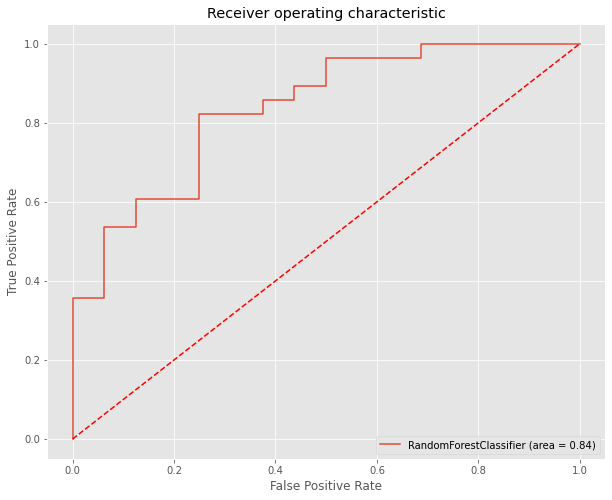

In [17]:
probs = rf_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize = (10, 8))
plt.plot(fpr, tpr, label='RandomForestClassifier (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
style.use("ggplot")
plt.savefig('14.png')
plt.show()